In [1]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model
from mlp_singledof_FD import MLP, MLPProjectionFilter

/home/alinjar/simple_training_warm_start


In [2]:
class TrajDataset(Dataset):
	"""Expert Trajectory Dataset."""
	def __init__(self, inp):
		
		# input
		self.inp = inp

	
	def __len__(self):
		return len(self.inp)    
			
	def __getitem__(self, idx):

		# Input
  
		inp = self.inp[idx]
		
				 
		return torch.tensor(inp).float()

In [3]:
def sample_uniform_trajectories(key, v_max, num_batch, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=-v_max,
        high=v_max,
        size=(num_batch, nvar)
    )
    return xi_samples, rng

In [4]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=50
timestep=0.05
v_max=1.0
a_max=2.0
j_max=5.0
p_max=180.0*np.pi/180.0 
theta_init=0.0
nvar_single = num_steps
nvar = num_dof * nvar_single

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

xi_samples, rng = sample_uniform_trajectories(42, v_max, num_batch, nvar)

inp = xi_samples

inp_mean, inp_std = inp.mean(), inp.std()

print("inp", inp.shape)

Using cuda device
inp (1000, 50)


In [6]:
# Using PyTorch Dataloader
train_dataset = TrajDataset(inp)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)



model = MLPProjectionFilter(mlp=mlp,num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max, 
							theta_init=theta_init).to(device)

print(type(model))                            

<class 'mlp_singledof_FD.MLPProjectionFilter'>


In [7]:
#Training

epochs = 400
step, beta = 0, 1.0 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-2, weight_decay=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)
losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp) in tqdm(train_loader):
        
        # Input and Output 
        inp = inp.to(device)
        

        xi_projected, accumulated_res_fixed_point, accumulated_res_primal, accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp)
        primal_loss, fixed_point_loss, projection_loss, loss = model.mlp_loss(accumulated_res_primal, accumulated_res_fixed_point, inp, xi_projected)

        
        optimizer.zero_grad() #clears the gradients of the model parameters
        loss.backward() #computes the gradients of the model parameters
        optimizer.step() #updates the model parameters
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        projection_losses.append(projection_loss.detach().cpu().numpy())
        

    if epoch % 10 == 0:    
        print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.4f}, primal loss: {np.average(primal_losses):.4f}, \
    fixed_point loss: {np.average(fixed_point_losses):.4f}, regression loss: {np.average(projection_losses):.4f}")
    #step += 0.07 #0.15
    # scheduler.step()
    
    os.makedirs("./training_weights", exist_ok=True)
    if loss <= last_loss:
            torch.save(model.state_dict(), f"./training_weights/mlp_learned_proj_manipulator.pth")
            last_loss = loss
    avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), \
    avg_projection_loss.append(np.average(projection_losses)), avg_fixed_point_loss.append(np.average(fixed_point_losses))

100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 1, Train Loss: 158418.4688, primal loss: 120.1956,     fixed_point loss: 158298.2188, regression loss: 0.4761


100%|██████████| 1/1 [00:00<00:00, 71.43it/s]


Epoch: 11, Train Loss: 97794.0469, primal loss: 75.0704,     fixed_point loss: 97718.9297, regression loss: 0.4651


100%|██████████| 1/1 [00:00<00:00, 71.97it/s]


Epoch: 21, Train Loss: 42476.6211, primal loss: 33.3117,     fixed_point loss: 42443.2656, regression loss: 0.4425


100%|██████████| 1/1 [00:00<00:00, 72.84it/s]


Epoch: 31, Train Loss: 18497.9180, primal loss: 16.0118,     fixed_point loss: 18481.8633, regression loss: 0.4304


100%|██████████| 1/1 [00:00<00:00, 54.57it/s]


Epoch: 41, Train Loss: 11677.3066, primal loss: 10.2564,     fixed_point loss: 11667.0098, regression loss: 0.3991


100%|██████████| 1/1 [00:00<00:00, 71.80it/s]


Epoch: 51, Train Loss: 7128.7319, primal loss: 6.4593,     fixed_point loss: 7122.2319, regression loss: 0.4051


100%|██████████| 1/1 [00:00<00:00, 72.87it/s]


Epoch: 61, Train Loss: 5386.7744, primal loss: 5.0020,     fixed_point loss: 5381.7354, regression loss: 0.3719


100%|██████████| 1/1 [00:00<00:00, 74.53it/s]


Epoch: 71, Train Loss: 4428.0679, primal loss: 3.9340,     fixed_point loss: 4424.0962, regression loss: 0.3742


100%|██████████| 1/1 [00:00<00:00, 69.71it/s]


Epoch: 81, Train Loss: 3933.8132, primal loss: 3.3624,     fixed_point loss: 3930.4153, regression loss: 0.3564


100%|██████████| 1/1 [00:00<00:00, 71.72it/s]


Epoch: 91, Train Loss: 2807.2476, primal loss: 2.4590,     fixed_point loss: 2804.7517, regression loss: 0.3682


100%|██████████| 1/1 [00:00<00:00, 69.84it/s]


Epoch: 101, Train Loss: 2121.8076, primal loss: 1.9780,     fixed_point loss: 2119.7947, regression loss: 0.3502


100%|██████████| 1/1 [00:00<00:00, 71.22it/s]


Epoch: 111, Train Loss: 1465.5612, primal loss: 1.3850,     fixed_point loss: 1464.1373, regression loss: 0.3885


100%|██████████| 1/1 [00:00<00:00, 68.99it/s]


Epoch: 121, Train Loss: 1083.6115, primal loss: 1.0249,     fixed_point loss: 1082.5519, regression loss: 0.3461


100%|██████████| 1/1 [00:00<00:00, 72.04it/s]


Epoch: 131, Train Loss: 553.6592, primal loss: 0.5715,     fixed_point loss: 553.0532, regression loss: 0.3455


100%|██████████| 1/1 [00:00<00:00, 69.81it/s]


Epoch: 141, Train Loss: 456.5741, primal loss: 0.4481,     fixed_point loss: 456.0921, regression loss: 0.3393


100%|██████████| 1/1 [00:00<00:00, 71.90it/s]


Epoch: 151, Train Loss: 311.7115, primal loss: 0.3238,     fixed_point loss: 311.3539, regression loss: 0.3375


100%|██████████| 1/1 [00:00<00:00, 66.85it/s]


Epoch: 161, Train Loss: 285.6436, primal loss: 0.2804,     fixed_point loss: 285.3296, regression loss: 0.3356


100%|██████████| 1/1 [00:00<00:00, 72.64it/s]


Epoch: 171, Train Loss: 198.5703, primal loss: 0.2027,     fixed_point loss: 198.3341, regression loss: 0.3346


100%|██████████| 1/1 [00:00<00:00, 61.98it/s]


Epoch: 181, Train Loss: 266.0667, primal loss: 0.2380,     fixed_point loss: 265.7950, regression loss: 0.3367


100%|██████████| 1/1 [00:00<00:00, 69.88it/s]


Epoch: 191, Train Loss: 264.8419, primal loss: 0.2359,     fixed_point loss: 264.5728, regression loss: 0.3331


100%|██████████| 1/1 [00:00<00:00, 73.73it/s]


Epoch: 201, Train Loss: 199.4249, primal loss: 0.1865,     fixed_point loss: 199.2040, regression loss: 0.3436


100%|██████████| 1/1 [00:00<00:00, 77.20it/s]


Epoch: 211, Train Loss: 165.8026, primal loss: 0.1514,     fixed_point loss: 165.6177, regression loss: 0.3353


100%|██████████| 1/1 [00:00<00:00, 60.35it/s]


Epoch: 221, Train Loss: 112.9325, primal loss: 0.1110,     fixed_point loss: 112.7880, regression loss: 0.3339


100%|██████████| 1/1 [00:00<00:00, 67.25it/s]


Epoch: 231, Train Loss: 117.5756, primal loss: 0.1107,     fixed_point loss: 117.4314, regression loss: 0.3345


100%|██████████| 1/1 [00:00<00:00, 74.42it/s]


Epoch: 241, Train Loss: 208.2287, primal loss: 0.1798,     fixed_point loss: 208.0156, regression loss: 0.3323


100%|██████████| 1/1 [00:00<00:00, 71.71it/s]


Epoch: 251, Train Loss: 196.0778, primal loss: 0.1750,     fixed_point loss: 195.8693, regression loss: 0.3345


100%|██████████| 1/1 [00:00<00:00, 49.48it/s]


Epoch: 261, Train Loss: 86.9586, primal loss: 0.0846,     fixed_point loss: 86.8408, regression loss: 0.3324


100%|██████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch: 271, Train Loss: 67.6392, primal loss: 0.0668,     fixed_point loss: 67.5391, regression loss: 0.3330


100%|██████████| 1/1 [00:00<00:00, 52.93it/s]


Epoch: 281, Train Loss: 62.9492, primal loss: 0.0595,     fixed_point loss: 62.8566, regression loss: 0.3315


100%|██████████| 1/1 [00:00<00:00, 72.72it/s]


Epoch: 291, Train Loss: 57.3959, primal loss: 0.0534,     fixed_point loss: 57.3094, regression loss: 0.3308


100%|██████████| 1/1 [00:00<00:00, 70.56it/s]


Epoch: 301, Train Loss: 50.5817, primal loss: 0.0494,     fixed_point loss: 50.4993, regression loss: 0.3303


100%|██████████| 1/1 [00:00<00:00, 70.53it/s]


Epoch: 311, Train Loss: 41.6951, primal loss: 0.0404,     fixed_point loss: 41.6217, regression loss: 0.3301


100%|██████████| 1/1 [00:00<00:00, 50.30it/s]


Epoch: 321, Train Loss: 31.8389, primal loss: 0.0302,     fixed_point loss: 31.7757, regression loss: 0.3301


100%|██████████| 1/1 [00:00<00:00, 71.78it/s]


Epoch: 331, Train Loss: 24.1973, primal loss: 0.0233,     fixed_point loss: 24.1410, regression loss: 0.3302


100%|██████████| 1/1 [00:00<00:00, 70.80it/s]


Epoch: 341, Train Loss: 21.8228, primal loss: 0.0207,     fixed_point loss: 21.7690, regression loss: 0.3301


100%|██████████| 1/1 [00:00<00:00, 54.15it/s]


Epoch: 351, Train Loss: 32.0020, primal loss: 0.0288,     fixed_point loss: 31.9404, regression loss: 0.3290


100%|██████████| 1/1 [00:00<00:00, 72.91it/s]


Epoch: 361, Train Loss: 33.8400, primal loss: 0.0295,     fixed_point loss: 33.7774, regression loss: 0.3306


100%|██████████| 1/1 [00:00<00:00, 61.78it/s]


Epoch: 371, Train Loss: 30.4449, primal loss: 0.0286,     fixed_point loss: 30.3833, regression loss: 0.3301


100%|██████████| 1/1 [00:00<00:00, 69.39it/s]


Epoch: 381, Train Loss: 28.0039, primal loss: 0.0243,     fixed_point loss: 27.9463, regression loss: 0.3322


100%|██████████| 1/1 [00:00<00:00, 69.57it/s]


Epoch: 391, Train Loss: 11.2193, primal loss: 0.0110,     fixed_point loss: 11.1751, regression loss: 0.3312


100%|██████████| 1/1 [00:00<00:00, 74.21it/s]


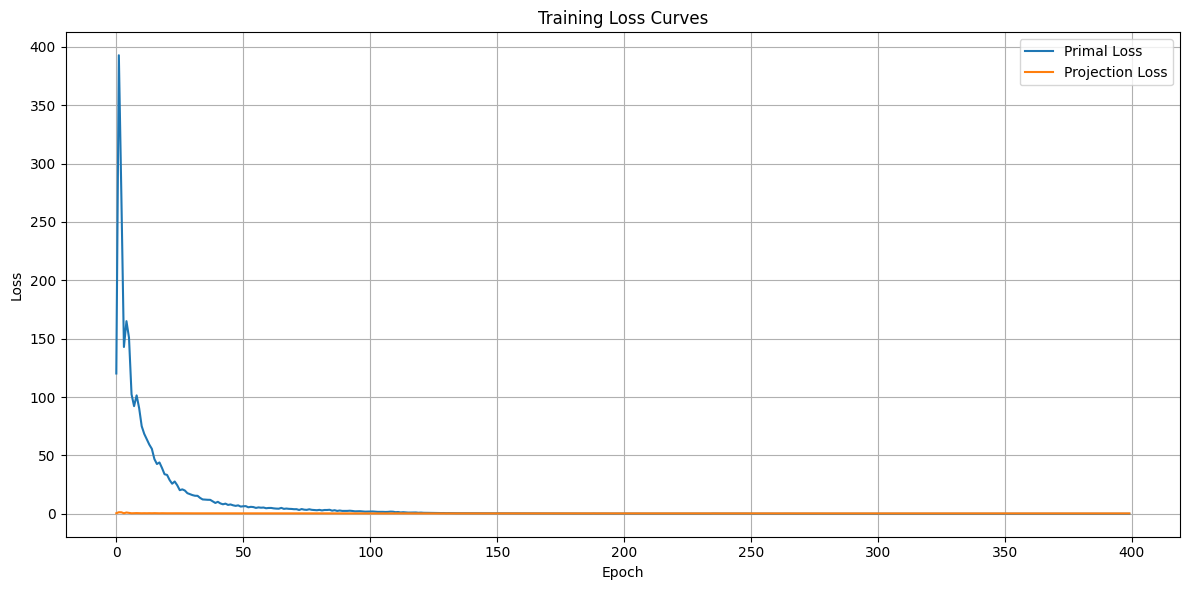

In [10]:
# Plot training losses

plt.figure(figsize=(12, 6))

#plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
#plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')

plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()